In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.optimizers import Adam

**Part** **1**

In [3]:
# Load the dataset
url = '/content/drive/MyDrive/Colab Notebooks/BUS_Data.csv'
data = pd.read_csv(url)

# Modify trip_id for better readability
data['trip_id'] = data['trip_id'].apply(lambda x: f'route_{x[-6:]}')

# Verify congestion categories and encode 'Degree_of_congestion'
print(data['Degree_of_congestion'].unique())  # Check unique values

# Encode 'Degree_of_congestion' into numerical values
congestion_mapping = {
    'Very smooth': 1,
    'Smooth': 2,
    'Mild congestion': 3,
    'Heavy congestion': 4
}
data['congestion_level'] = data['Degree_of_congestion'].map(congestion_mapping)

data.head()

['Very smooth' 'Smooth' 'Heavy congestion' 'Mild congestion']


,stop_id_from,stop_id_to,trip_id,arrival_time,time,speed,Number_of_trips,SRI,Degree_of_congestion,congestion_level
0,36156,38709,route_0855_0,09:13:54,0.027222,14.479565,9.0,-0.40816322,Very smooth,1
1,36156,38709,route_0845_0,09:03:01,0.032222,12.232736,9.0,1.2068965,Smooth,2
2,36156,38709,route_0915_0,09:15:00,0.058333,6.757130,9.0,5.142857,Heavy congestion,4
3,36156,38709,route_0905_0,09:05:00,0.033611,11.727251,9.0,1.570248,Smooth,2
4,36156,38709,route_0900_0,09:00:00,0.058333,6.757130,9.0,5.142857,Heavy congestion,4


In [ ]:
# Convert arrival_time
data['arrival_time'] = pd.to_datetime(data['arrival_time'], format='%H:%M:%S')

# Extract hour and minute for Time of Day analysis
data['arrival_hour'] = data['arrival_time'].dt.hour
data['arrival_minute'] = data['arrival_time'].dt.minute

In [ ]:
# Handle infinite values in 'speed'
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values in speed with median
data['speed'].fillna(data['speed'].median(), inplace=True)

<ipython-input-10-edcd767a7e4c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['speed'].fillna(data['speed'].median(), inplace=True)


In [ ]:
# Handle missing values
data.dropna(inplace=True)

# Descriptive statistics
print(data.describe())

       stop_id_from    stop_id_to                   arrival_time  \
count  66546.000000  66546.000000                          66546   
mean   33067.236243  33094.052355  1900-01-01 14:03:35.780903424   
min      386.000000    386.000000            1900-01-01 09:00:00   
25%    33492.000000  33492.000000            1900-01-01 14:03:16   
50%    38784.000000  38784.000000            1900-01-01 14:28:24   
75%    39281.000000  39283.000000            1900-01-01 14:53:06   
max    40516.000000  40516.000000            1900-01-01 18:19:35   
std    11908.262442  11873.438387                            NaN   

               time         speed  Number_of_trips  congestion_level  \
count  66546.000000  66546.000000     66546.000000      66546.000000   
mean       0.019432     41.462082        16.628182          2.119286   
min        0.000000      0.000000         1.000000          1.000000   
25%        0.009167     21.689701         4.000000          1.000000   
50%        0.015000     31.

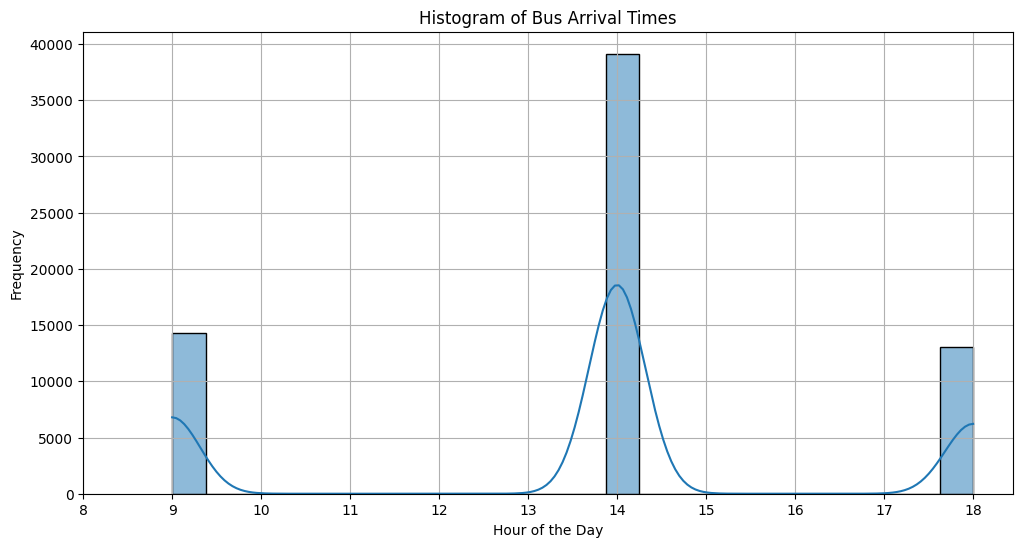

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data['arrival_hour'], bins=24, kde=True)
plt.title('Histogram of Bus Arrival Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(8, 19))
plt.grid()
plt.show()

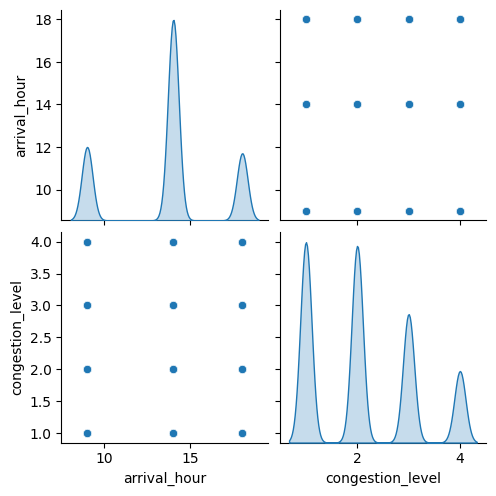

In [ ]:
# Pairplot to visualize arrival_hour vs congestion level
sns.pairplot(data[['arrival_hour', 'congestion_level']], diag_kind='kde')
plt.show()

**Part** **2**

In [ ]:
# Sorting by trip and stop sequence
data.sort_values(by=['trip_id', 'arrival_time'], inplace=True)

# Generate 'prev_arrival_time' and compute 'delay'
data['prev_arrival_time'] = data.groupby('trip_id')['arrival_time'].shift(1)
data['delay'] = (data['arrival_time'] - data['prev_arrival_time']).dt.total_seconds()

# Handling missing values
data.dropna(subset=['delay'], inplace=True)

In [ ]:
# Feature Engineering: Extract time-based features
data['is_peak'] = data['arrival_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 13 <= x <= 15 or 16 <= x <= 19 else 0)

# Select features
features = ['stop_id_from', 'stop_id_to', 'arrival_hour', 'is_peak', 'congestion_level']
X = data[features]
y = data['delay']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Model 2: XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Model 3: LSTM
X_train_lstm = np.expand_dims(X_train.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

y_pred_lstm = model.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1661/1661 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 12382.4912
Epoch 2/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5798.3652
Epoch 3/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11631.1582
Epoch 4/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 12820.8203
Epoch 5/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7060.7666
Epoch 6/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 12882.6982
Epoch 7/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 22052.6484
Epoch 8/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 4493.0117
Epoch 9/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 17801.5195
Epoch 10/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 18025.7539
Epoch 11/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 9851.9883
Epoch 12/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 14598.5811
Epoch 13/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3461.4302
Epoch 14/20
1661/1661 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - lo

In [ ]:
# Print Results
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")

Random Forest RMSE: 58.59
XGBoost RMSE: 59.58
LSTM RMSE: 13.00


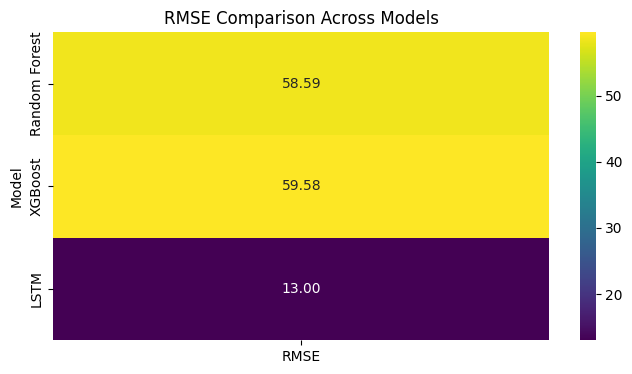

In [ ]:
# DataFrame for RMSE values
rmse_values = {
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'RMSE': [rmse_rf, rmse_xgb, rmse_lstm]
}
rmse_df = pd.DataFrame(rmse_values)

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(rmse_df.set_index('Model'), annot=True, cmap='viridis', fmt='.2f', cbar=True)
plt.title('RMSE Comparison Across Models')
plt.show()